# Data Analysis
Date: 1/29/2021

## About this Notebook
This notebook is to analyze the data for the use by the models. <br><br>

## Adminstrative Activity

### Import Packages

In [1]:
import os, json, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time #duration

from collections import Counter

#NTLK
from nltk.corpus import stopwords  # stopwords
from nltk.stem import WordNetLemmatizer # Lemmatization
import re, string #Text cleaning

from IPython.display import display, HTML #improve visuals

#Custom Code
from bin.text_cleaner import text_cleaner
from bin. html_functions import ez_display as d

In [2]:
d("<b>Current Python Version Used:</b> Python " +  sys.version.split('(')[0].strip())

### Variables

In [3]:
data_folder = "data"
raw_data_folder = os.path.join(data_folder,'RAW')
images_folder = "images"
graph_folder = os.path.join(images_folder,"graphs")
word_freq_folder = os.path.join(data_folder,"word_frequency")
cleaned_data_folder = os.path.join(data_folder,'cleaned')
cleaned_data_filename = "articles.feather"
cleaned_data_filepath = os.path.join(cleaned_data_folder,cleaned_data_filename)
article_filenames = ['articles1.csv', 'articles2.csv', 'articles3.csv']
text_stats_filename = "text_analysis.xlsx"
publication_scorecard_filename = "publication_scorecard.json"
publication_scorecard_filepath = os.path.join(data_folder,publication_scorecard_filename)
text_stats_filepath = os.path.join(data_folder,text_stats_filename)

## Creating Directories if not available

In [4]:
if os.path.isdir(graph_folder) == False:
    if os.path.isdir(images_folder) == False:
        os.mkdir(images_folder)
    os.mkdir(graph_folder)
if os.path.isdir(word_freq_folder) == False:
    os.mkdir(word_freq_folder)

## Pulling Data

In [5]:
%%time
df = pd.read_feather(cleaned_data_filepath)

Wall time: 1.89 s


In [6]:
d('<b>DataFrame Shape:</b> '+str(df.shape))
df.head()

,id,title,publication,author,date,year,month,url,content,simple_clean,stopwords_clean,lemming_clean
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,None,WASHINGTON — Congressional Republicans have...,WASHINGTON Congressional Republicans fear come...,WASHINGTON Congressional Republicans fear come...,WASHINGTON Congressional Republicans fear come...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,None,"After the bullet shells get counted, the blood...",bullet shells counted blood dries votive candl...,bullet shell counted blood dry votive candle b...,bullet shell counted blood dry votive candle b...
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,None,"When Walt Disney’s “Bambi” opened in 1942, cri...",Walt Disneys Bambi opened 1942 critics praised...,Walt Disneys Bambi opened 1942 critic praised ...,Walt Disneys Bambi opened 1942 critic praised ...
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,None,"Death may be the great equalizer, but it isn’t...",Death great equalizer necessarily evenhanded f...,Death great equalizer necessarily evenhanded f...,Death great equalizer necessarily evenhanded f...
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,None,"SEOUL, South Korea — North Korea’s leader, ...",SEOUL South Korea North Koreas leader said Sun...,SEOUL South Korea North Koreas leader said Sun...,SEOUL South Korea North Koreas leader said Sun...


## Adding Political Spectrum Score

In [7]:
with open(publication_scorecard_filepath) as fp:
    scorecard = json.load(fp)

In [8]:
pd.DataFrame.from_dict(scorecard,orient='index',columns=['Spectrum Score'])

,Spectrum Score
New York Times,-5
Breitbart,10
CNN,-5
Business Insider,0
Atlantic,-5
Fox News,5
Talking Points Memo,-5
Buzzfeed News,-10
National Review,10
New York Post,5


In [9]:
for k,v in scorecard.items():
    scorecard[k] = v/10
    print(f"{k}: {scorecard[k]}")

New York Times: -0.5
Breitbart: 1.0
CNN: -0.5
Business Insider: 0.0
Atlantic: -0.5
Fox News: 0.5
Talking Points Memo: -0.5
Buzzfeed News: -1.0
National Review: 1.0
New York Post: 0.5
Guardian: -0.5
NPR: 0.0
Reuters: 0.0
Vox: -1.0
Washington Post: -0.5


In [10]:
df['political_score'] = df['publication'].apply(lambda x: scorecard[x])

## Review of Data

In [11]:
text_stats = {} #For Storage

### Empty URL Values

In [12]:
sum(df.url.isnull())

57011

### Publication Data

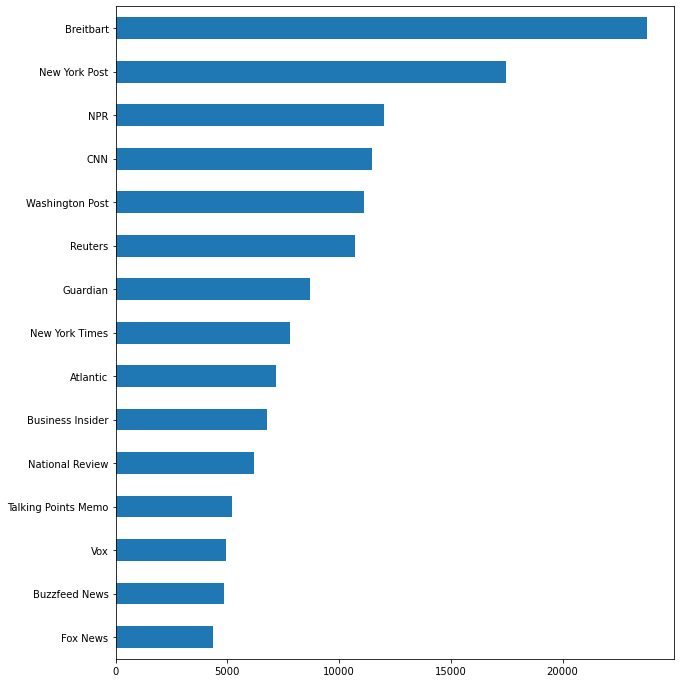

In [13]:
pub_review = df['publication'].value_counts(ascending=True).to_frame()
pub_review['percent'] = pub_review['publication']/len(df)
pub_review.rename(columns={'publication':'count'},inplace=True)
text_stats['Publication Value Count'] = pub_review
pub_review_bar = pub_review['count'].plot.barh(figsize=(10,12),table=False,label=True)
fn = os.path.join(graph_folder,'Publication Distribution Review.png')
pub_review_bar.figure.savefig(fn)

### Year Review

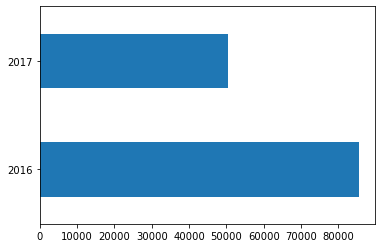

In [14]:
year_review = df['year'].value_counts(ascending=True).to_frame()
year_review.set_index(year_review.index.astype(int),inplace=True)
year_review.rename(columns={'year':'count'},inplace=True)
year_review.sort_index(inplace=True)
text_stats['Year Review Value Count'] = year_review
year_review_bar = year_review['count'].loc[year_review['count']>=10000].plot.barh()
fn = os.path.join(graph_folder,'Article Year Review.png')
year_review_bar.figure.savefig(fn)

### Month Review

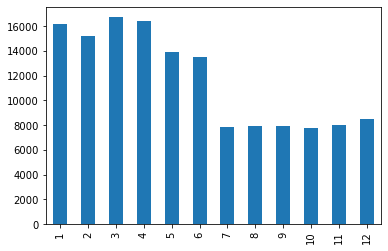

In [15]:
month_review = df['month'].value_counts().to_frame()
month_review.set_index(month_review.index.astype(int),inplace=True)
month_review.rename(columns={'month':'count'},inplace=True)
month_review.sort_index(inplace=True)
text_stats['Month Review Value Count'] = month_review
month_review_bar = month_review['count'].plot.bar()
fn = os.path.join(graph_folder,'Article Month Review.png')
month_review_bar.figure.savefig(fn)

### Political Spectrum Review

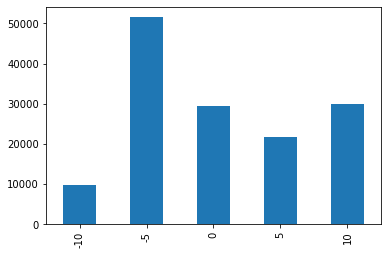

In [16]:
temp = df['political_score']*10
ps_review = temp.value_counts().to_frame()
ps_review.set_index(ps_review.index.astype(int),inplace=True)
ps_review.rename(columns={'political_score':'count'},inplace=True)
ps_review.sort_index(inplace=True)
text_stats['Political Spectrum Review Value Count'] = ps_review
ps_review_bar = ps_review['count'].plot.bar()
fn = os.path.join(graph_folder,'Political Spectrum Review.png')
ps_review_bar.figure.savefig(fn)

In [17]:
df.head()

,id,title,publication,author,date,year,month,url,content,simple_clean,stopwords_clean,lemming_clean,political_score
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,None,WASHINGTON — Congressional Republicans have...,WASHINGTON Congressional Republicans fear come...,WASHINGTON Congressional Republicans fear come...,WASHINGTON Congressional Republicans fear come...,-0.5
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,None,"After the bullet shells get counted, the blood...",bullet shells counted blood dries votive candl...,bullet shell counted blood dry votive candle b...,bullet shell counted blood dry votive candle b...,-0.5
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,None,"When Walt Disney’s “Bambi” opened in 1942, cri...",Walt Disneys Bambi opened 1942 critics praised...,Walt Disneys Bambi opened 1942 critic praised ...,Walt Disneys Bambi opened 1942 critic praised ...,-0.5
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,None,"Death may be the great equalizer, but it isn’t...",Death great equalizer necessarily evenhanded f...,Death great equalizer necessarily evenhanded f...,Death great equalizer necessarily evenhanded f...,-0.5
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,None,"SEOUL, South Korea — North Korea’s leader, ...",SEOUL South Korea North Koreas leader said Sun...,SEOUL South Korea North Koreas leader said Sun...,SEOUL South Korea North Koreas leader said Sun...,-0.5


## Text Review

In [18]:
text_cols = ['content','simple_clean','stopwords_clean','lemming_clean']

In [19]:
%%time
frame_storage = {}
for col in text_cols:
    d(f'Working on {col}')
    frame_storage[col] = {}
    char_len = df[col].str.len().describe().to_frame().round(2)
    word_len = df[col].str.split().str.len().describe().to_frame().round(2)
    frame_storage[col]['Char Length'] = char_len
    frame_storage[col]['Word Length'] = word_len
    d('-----Building Index')
    text_index = df[col].str.split()
    text_index = [word for comment in text_index for word in comment]
    word_freq = Counter(text_index).most_common()
    word_freq = pd.DataFrame(word_freq,columns=['Words','Count'])
    frame_storage[col]['Word Frequency'] = word_freq
    frame_storage[col]['Unique Word Count'] = len(word_freq['Words'])
    frame_storage[col]['Total Words'] = sum(word_freq['Count'])

Wall time: 1min 32s


## Simplifying visual for Text Review

In [20]:
analysis_review = ['Char Length','Word Length','Word Frequency']
for analysis in analysis_review:
    frames = []
    for col in text_cols:
        if analysis == 'Word Frequency':
            frame = frame_storage[col][analysis][:20].copy()
            new_col_names = dict([(col_name,col+'_'+col_name) for col_name in frame.columns])
            frame.rename(columns=new_col_names,inplace=True)
            frames.append(frame)
        else:
            frames.append(frame_storage[col][analysis])
    text_stats[analysis] = pd.concat(frames,axis=1,sort=False)

In [21]:
for analysis in analysis_review:
    d(f'<h3>{analysis}</h3>')
    d(text_stats[analysis].to_html())

,content,simple_clean,stopwords_clean,lemming_clean
count,142570.00,142570.00,142570.00,142570.00
mean,4414.32,2865.07,2813.55,2813.55
std,4431.00,2805.58,2754.71,2754.71
min,1.00,0.00,0.00,0.00
25%,2033.00,1324.00,1302.00,1302.00
50%,3536.00,2305.00,2265.00,2265.00
75%,5509.00,3615.00,3548.00,3548.00
max,292586.00,176141.00,173590.00,173590.00


,content,simple_clean,stopwords_clean,lemming_clean
count,142570.00,142570.00,142570.00,142570.00
mean,741.46,375.51,375.22,375.22
std,752.86,366.53,366.19,366.19
min,0.00,0.00,0.00,0.00
25%,341.00,175.00,175.00,175.00
50%,592.00,303.00,303.00,303.00
75%,921.00,471.00,471.00,471.00
max,50035.00,22514.00,22454.00,22454.00


,content_Words,content_Count,simple_clean_Words,simple_clean_Count,stopwords_clean_Words,stopwords_clean_Count,lemming_clean_Words,lemming_clean_Count
0,the,5300503,said,570938,said,570938,said,570938
1,to,2907614,Trump,356213,Trump,356213,Trump,356213
2,of,2636402,would,260784,would,260784,would,260784
3,a,2418975,people,232434,people,238104,people,238104
4,and,2366272,also,176886,year,228185,year,228185
5,in,1920933,like,169832,also,176886,also,176886
6,that,1317722,could,141744,like,174009,like,174009
7,is,947579,time,138578,time,167630,time,167630
8,for,937745,years,128383,could,141744,could,141744
9,on,857573,says,122797,say,122798,say,122798


### Unique Count

In [22]:
%%time
STOPWORDS = stopwords.words('english')
STOPWORDS = [word.translate(str.maketrans('','',string.punctuation)) for word in STOPWORDS] # Removing punctuation
corpus_count = {}
uni_count_cols = ['Unique Word Count','Total Words','Words Appear Once','Stop Words','Less than 3 chars']
for col in text_cols:
    unique = frame_storage[col]['Unique Word Count']
    total = frame_storage[col]['Total Words']
    word_freq= frame_storage[col]['Word Frequency']
    words_appear_once = len(word_freq[word_freq['Count']==1])
    stop_words = len(word_freq[word_freq['Words'].isin(STOPWORDS)])
    lt_3 = len(word_freq[word_freq['Words'].str.len() < 3])
    corpus_count[col] = [unique,total,words_appear_once,stop_words,lt_3]
corpus_count = pd.DataFrame.from_dict(corpus_count,orient='index',columns=uni_count_cols)
text_stats['Unique-Total'] = corpus_count
d('<h3>Unique to Total Word Count Review</h3>')
d(corpus_count.to_html())

,Unique Word Count,Total Words,Words Appear Once,Stop Words,Less than 3 chars
content,1096252,105709254,533815,165,3547
simple_clean,364247,53536194,139154,0,0
stopwords_clean,349215,53494868,136430,0,21
lemming_clean,349215,53494868,136430,0,21


Wall time: 1.46 s


### Word Distribution

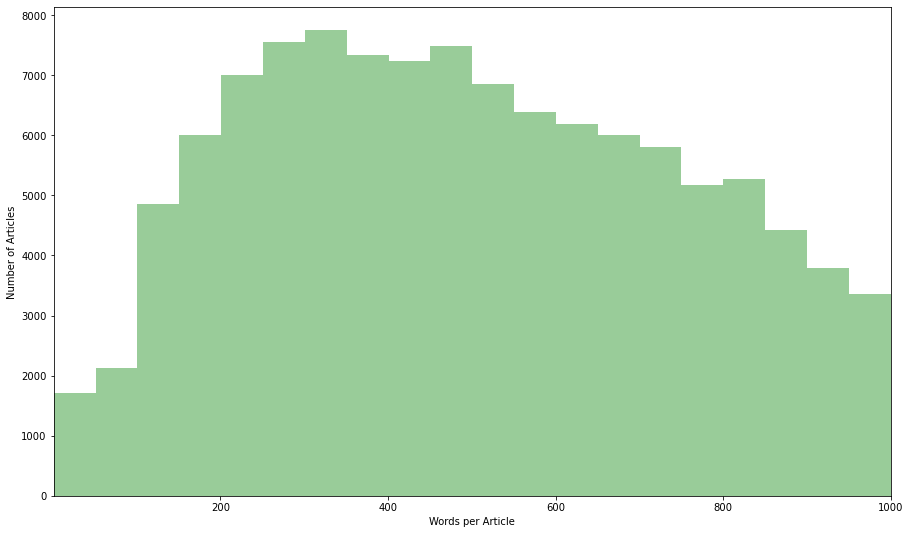

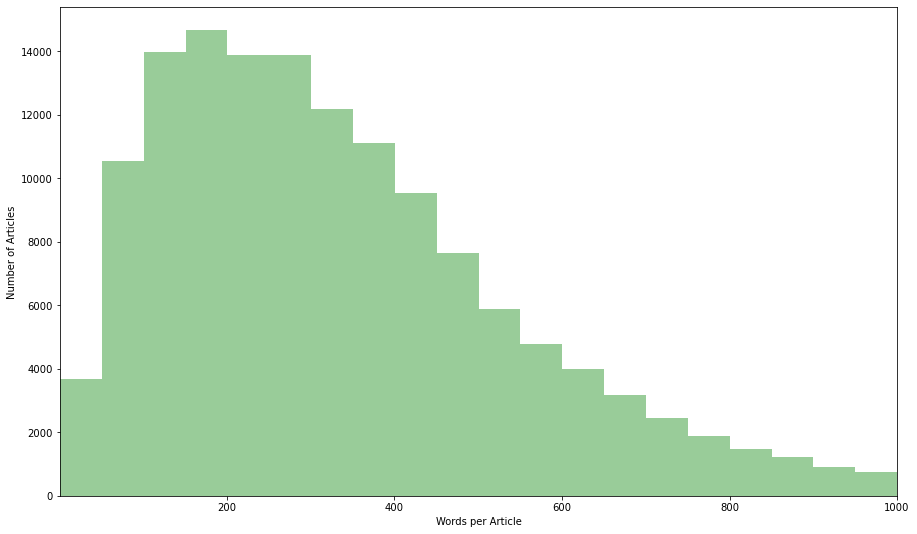

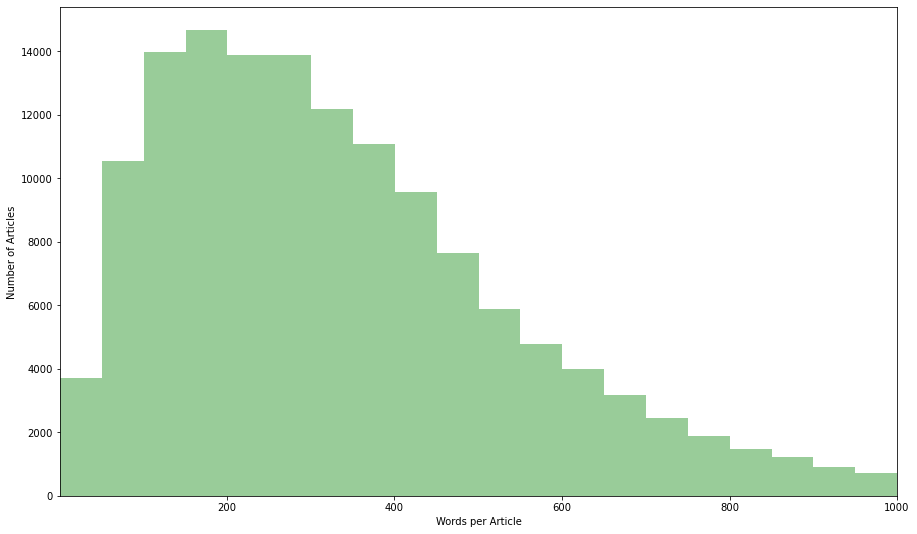

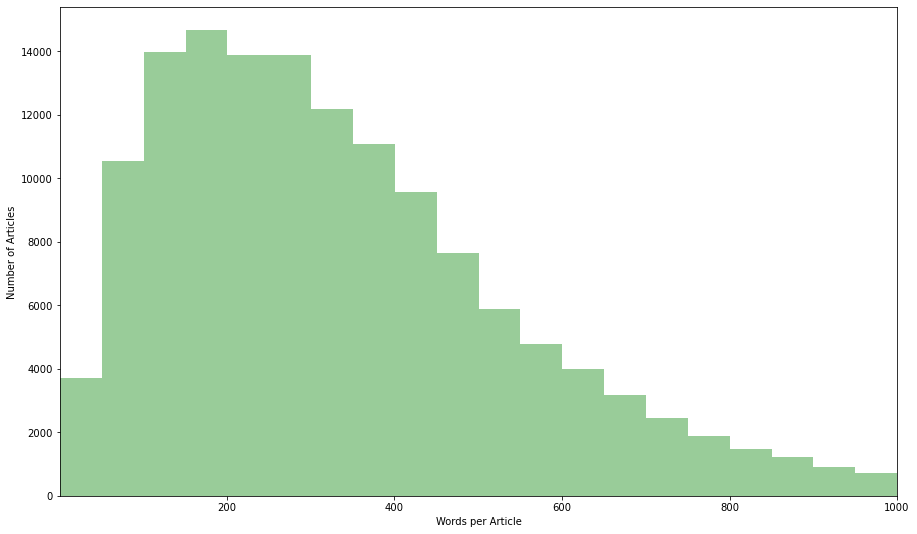

Wall time: 25.3 s


In [23]:
%%time
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
for col in text_cols:
    plt.figure(figsize=[15,9])
    article_sizes = df[col].str.split().str.len()
    size_hist = sns.distplot(article_sizes,bins=20,hist=True,kde=False,hist_kws={'range':[1,1000]},color='g')
    size_hist.set_xlim(1,1000)
    # plt.xticks(np.arange(1,21,step=1))
    plt.xlabel('Words per Article')
    plt.ylabel('Number of Articles')
    # plt.title(f'Distribution of words per article for {col}')
    plt_fn = os.path.join(graph_folder,f'{col}_word_distribution.png')
    plt.savefig(plt_fn)
    plt.show()

## Storing Text Analysis

In [24]:
with pd.ExcelWriter(text_stats_filepath) as writer:
    for k,v in text_stats.items():
        v.to_excel(writer, sheet_name=k)

## Saving Word Frequencies

In [25]:
for col in text_cols:
    fn = os.path.join(word_freq_folder,f'{col}_word_frequency.feather')
    frame_storage[col]['Word Frequency'].to_feather(path=fn)

### Saving DataFrame

In [26]:
df.to_feather(path=cleaned_data_filepath)